In [1]:
#User-defined inputs and assumptions:

rf = 0.03      #Annualized risk free rate assumption
start = 1000   #The inital asset value for wealth index
floor = 0.8    #CPPI floor = 80% of the initial asset value (represents a 20% drawdown constraint)

In [2]:
import edhec_risk_kit as erk
import pandas as pd
import numpy as np

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

#Define "Risky" Assets
risky_r = ind_return["2000":][["Steel","Fin","Beer"]]

#Set up a Data Frame for the "Safe" Asset
safe_r = pd.DataFrame().reindex_like(risky_r) #gives you an empty dataframe of the same shape as risky_r
safe_r[:] = rf/12

In [3]:
#Make sure that risky_r.shape = safe_r.shape
risky_r.shape == safe_r.shape

True

Objective: write an algorithm for implementing CPPI and Drawdown Constraints (Dynamic Hedging).

For every unit of time:
1. Cushion = (Asset Value) minus (Floor Value): This is your risk budget
2. Compute an Allocation to Safe and Risky Asset = M(t)*Cushion
3. Recompute the Asset Value based on the returns

#### Side note: show how loops are relatively inefficient to numpy functions:

- It's good practice to avoid using loops with numpy because they require a lot more processing power than numpy functions.

In [4]:

def compound1(r):
    return (1+r).prod()-1
%timeit compound1(risky_r) #the processing power expended on compound1() expressed in units of time

def compound2(r):
    return np.exp(np.log(1+r).sum())-1 #Note that in numpy you can replace log(1+r) with log1p(r). This term is technically a for() loop, so log1p(r) is more efficient than log(1+r)
%timeit compound2(risky_r) #the processing power expended on compound2() expressed in time

def compound3(r):
    return np.exp(np.log1p(r).sum())-1
%timeit compound3(risky_r) #the processing power expended on compound3() expressed in units of time
      
def compound4(r):
    return np.expm1(np.log1p(r).sum()) #np.expm1 means exp()-1
%timeit compound4(risky_r) #the processing power expended on compound4() expressed in units of time

print("On average, numpy compound4() beats all other options by making good use of numpy functions")

464 µs ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
604 µs ± 55.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
506 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
443 µs ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
On average, numpy compound4() beats all other options by making good use of numpy functions


#### Now back to CPPI:

- Here, it's unavoidable... we must use a for() loop to run the algorithm for CPPI

In [5]:
dates = risky_r.index
n_steps = len(dates)
account_value = start #initailize account_value
floor_value = start*floor #initailize floor_value
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

#Implement the CPPI algorithim with a for() loop
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1) #constraint: risky_w cannot exceed 100% i.e., we do not allow levered CPPI investment (must borrow to finance risky_w > 100%)
    risky_w = np.maximum(risky_w, 0) #constraint: cannot short the risky asset
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    ## update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    ## populate account_history, cushion_history, risky_w_history
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    

<Axes: >

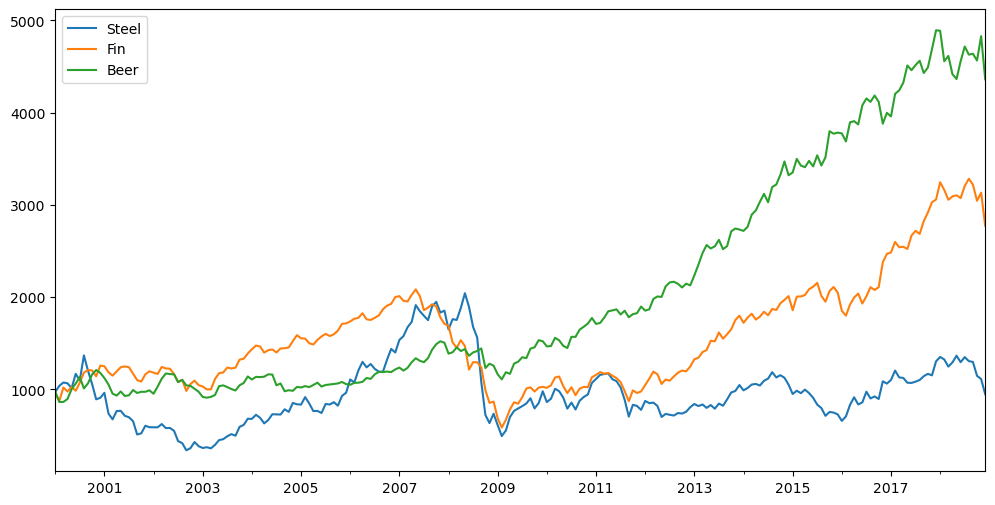

In [6]:
#Let's look at the growth of $1000 for a 100% allocaiton to each of our risky assets
risky_wealth = start*(1+risky_r).cumprod() #your compounded account value lacking any CPPI strategy
risky_wealth.plot(figsize=(12,6))

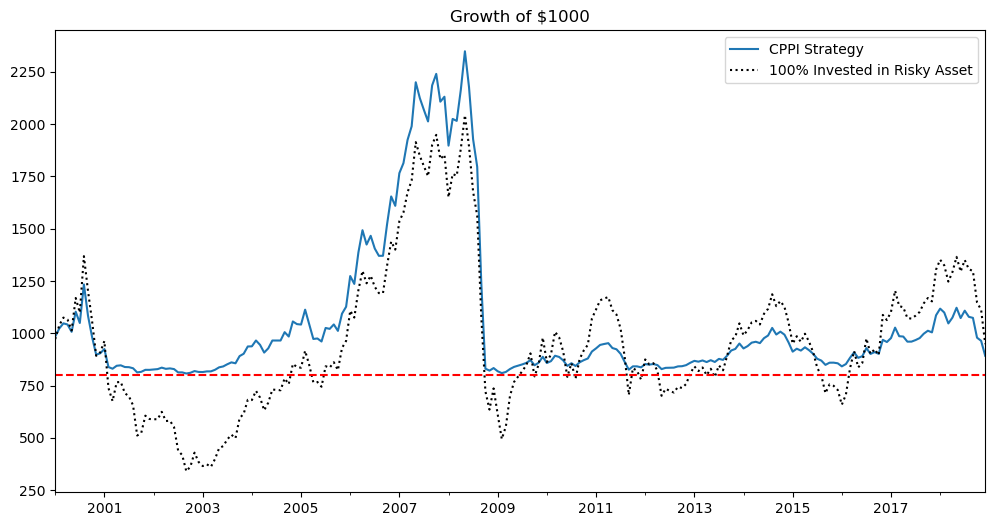

In [7]:
#Let's look at the value added by CPPI if our risky asset is an investment in the steel industry
ax = account_history["Steel"].plot(figsize=(12,6), legend=True, label="CPPI Strategy")
risky_wealth["Steel"].plot(ax=ax,figsize=(12,6), style="k:", legend=True, label="100% Invested in Risky Asset", title="Growth of $1000")
ax.axhline(y=floor_value, color="red", linestyle="--")

<Axes: title={'center': 'Historic Portfolio %Weight in Risky Asset as per CPPI Strategy'}>

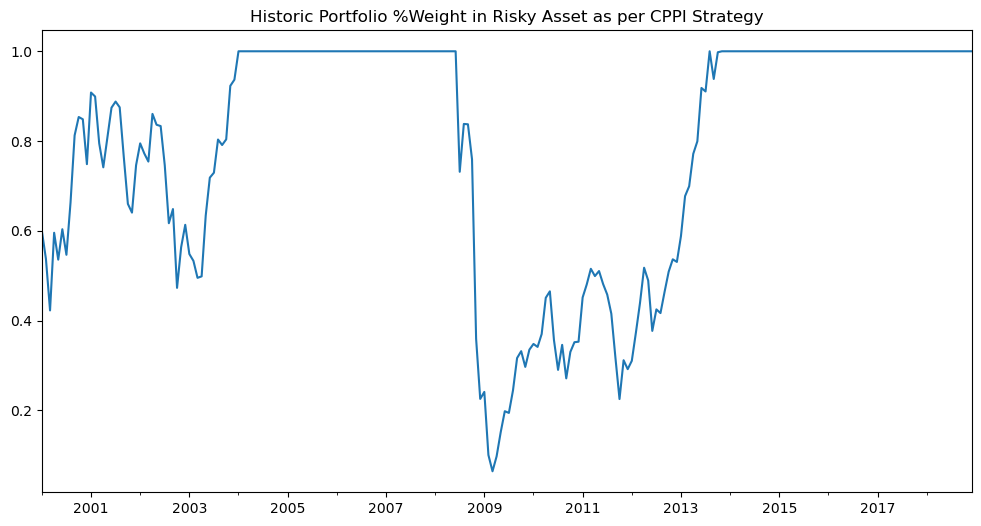

In [8]:
#Let's look at the allocation to our risky asset over history
risky_w_history["Fin"].plot(figsize=(12,6), title="Historic Portfolio %Weight in Risky Asset as per CPPI Strategy")